<a href="https://colab.research.google.com/github/furkanbk/Bone_age_prediction/blob/main/ML_HD_C2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Age detection using CNN with regression using hand-bone MRIs


- Part 1 of this notebook describes the data, basic cnn model, and preprocessing proposals.
- Part 2 of this notebook showcase different preprocessing methods' effect on - model accuracy and evalute memory / time efficiency.
- Part 3 of this notebook showcase model proposals.
-Part 4 of this notebook plots the best configurations, and comparison.

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from PIL import Image
import os
import random

%matplotlib inline
np.random.seed(4)

In [2]:
!pip install tf-models-official

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 45.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 61.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 565.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 78.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 106.3 MB/s eta 0:00:00
  Created wheel for seqeva

## Part 1


### Dataset


In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
cd '/content/drive/MyDrive/ML_HD_C2'


/content/drive/.shortcut-targets-by-id/1SdnBZOzsEir7hBdU_PsKhixJYL4F6ZI4/ML_HD_C2


In [11]:
training_dir = '/dataset/boneage-training-dataset.zip'
validation_dir = 'dataset/Bone Age Validation Set.zip'
test_dir = '/dataset/Bone Age Test Set.zip'

In [12]:
import zipfile
import os

current_path = os.getcwd()
zip_path = training_dir
full_path = os.path.join(current_path, zip_path.lstrip('/'))  # lstrip to remove leading slash

with zipfile.ZipFile(full_path, 'r') as zip_ref:
    file_list = zip_ref.namelist()

#ground_truth_path_name = file_list[0]
images_path_name = file_list[1:]

print("Number of files in the zip:", len(file_list))


Number of files in the zip: 12612


Number of images available

In [13]:
len(images_path_name)

12611

Randomly select N% of files


In [15]:
import random
n=1
subset = random.sample(images_path_name, int(len(images_path_name) * n))
print(len(subset), "files selected.")

12611 files selected.


Extracting dataset with selected files


In [16]:
output_dir = '/content/dataset_subset'

In [17]:
output_dir = '/content/dataset_subset'
with zipfile.ZipFile(full_path, 'r') as zip_ref:
    for file in subset:
        zip_ref.extract(file, output_dir)
#also extract the ground truth
    # zip_ref.extract(ground_truth_path_name, output_dir)

In [18]:
#read the ground truth labels
import pandas as pd

# for test : labels_df = pd.read_excel(os.path.join(output_dir, ground_truth_path_name))
labels_df = pd.read_csv("/content/drive/MyDrive/ML_HD_C2/dataset/train.csv")
labels_df.head()


id  boneage   male
0  1377      180  False
1  1378       12  False
2  1379       94  False
3  1380      120   True
4  1381       82  False

### EDA

#### Checking Image Dimensions for consistency


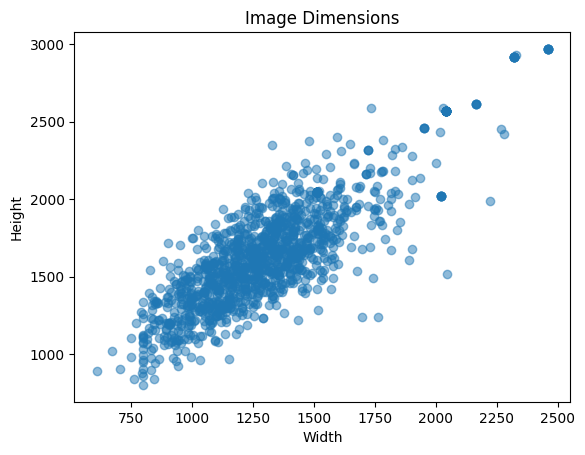

Min Width: 609 Max Width: 2460
Min Height: 801 Max Height: 2970


In [ ]:
from PIL import Image

dimensions = []
for file in subset:
    with Image.open(os.path.join(output_dir, file)) as img:
        dimensions.append(img.size)

widths, heights = zip(*dimensions)
plt.scatter(widths, heights, alpha=0.5)
plt.title("Image Dimensions")
plt.xlabel("Width")
plt.ylabel("Height")
plt.show()

print("Min Width:", min(widths), "Max Width:", max(widths))
print("Min Height:", min(heights), "Max Height:", max(heights))

Above plot shows that we need to standardise the image size in preprocessing part.

#### Image Color Analysis

In [ ]:
from collections import Counter
color_modes = []

for file in subset:
    with Image.open(os.path.join(output_dir, file)) as img:
        color_modes.append(img.mode)

print("Color Modes:", Counter(color_modes))

Color Modes: Counter({'L': 1261})


Above result shows us all the images are Grey Scale, no need to standardize

#### Image Pixel Densities

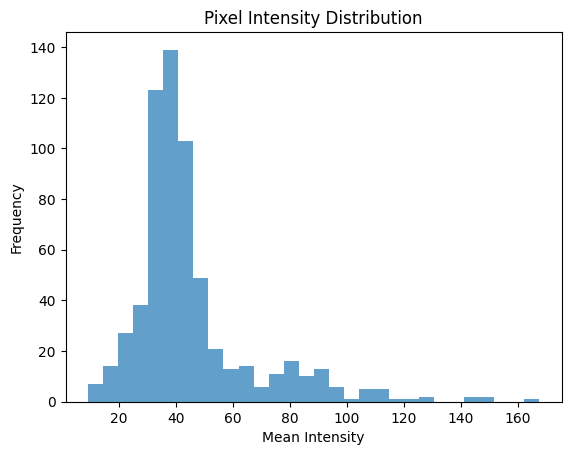

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

pixel_means = []
for file in subset:
    with Image.open(os.path.join(output_dir, file)) as img:
        pixel_means.append(np.array(img).mean())

plt.hist(pixel_means, bins=30, alpha=0.7)
plt.title("Pixel Intensity Distribution")
plt.xlabel("Mean Intensity")
plt.ylabel("Frequency")
plt.show()

Above histogram shows us inconsistencies, that will require us normalization for pixels to standard range in preprocessing part.


#### Image Augmentation Feasibility


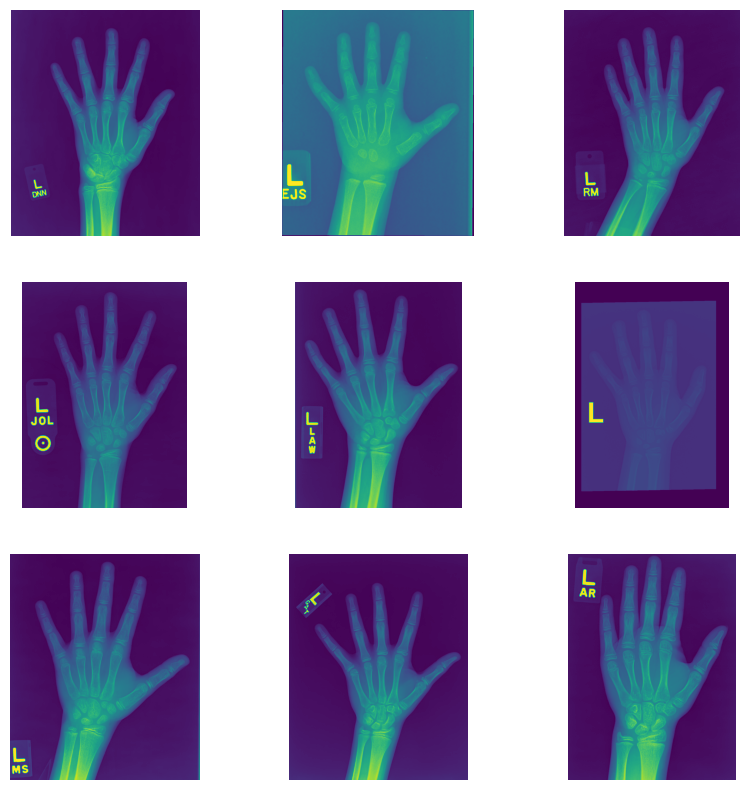

In [ ]:
import matplotlib.pyplot as plt

sample_images = random.sample(subset, 9)
plt.figure(figsize=(10, 10))
for i, file in enumerate(sample_images):
    with Image.open(os.path.join(output_dir, file)) as img:
        plt.subplot(3, 3, i + 1)
        plt.imshow(img)
        plt.axis("off")
plt.show()

Above, we printed some mri images from the dataset. As observed, the images are taken from completely non-uniform distances, quality of the images (and contrast) differ significantly, and the hands are with different rotation angles. This can introduce skewness in data. Zoom and rotation seems crucial in preprocessing stage.


### Preprocessing

#### Preprocessing functions

In [19]:
#remove the images other than those are in valid brightness levels
img_paths = []
for file in subset:
    img_paths.append(os.path.join(output_dir, file))

# pixel_means = np.array(pixel_means)
# valid_indices = np.where((pixel_means >= 30) & (pixel_means <= 120))[0]
# img_paths = [img_paths[i] for i in valid_indices]

In [20]:
import cv2


# Function to apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
def clahe_enhancement(img):

    # Create a CLAHE object with default parameters
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img_clahe = clahe.apply(img)  # Apply CLAHE

    # Return the enhanced image
    return img_clahe

def create_false_rgb_image(enhanced_img, fake_g_float, fake_b_float):
    # Create a 3-channel image by stacking the enhanced grayscale image across 3 channels
    false_rgb = np.stack([enhanced_img] * 3, axis=-1)

    # Modify the channels to create false color effect (you can change these values to your liking)
    # Example: emphasize each channel differently to create a false color effect
    false_rgb[:, :, 0] = enhanced_img  # Red channel
    false_rgb[:, :, 1] = enhanced_img * fake_g_float  # Green channel (slightly darker)
    false_rgb[:, :, 2] = enhanced_img * fake_b_float  # Blue channel (slightly brighter)

    # Ensure the values are in the valid range [0, 255] for image display
    false_rgb = np.clip(false_rgb, 0, 255).astype(np.uint8)

    return false_rgb
# Function to apply Gamma Correction
def gamma_correction(img, gamma=1.5):
    # Convert image to float32 and normalize
    img_float = img / 255.0
    # Apply gamma correction
    img_gamma = np.power(img_float, gamma)
    img_gamma = np.uint8(img_gamma * 255)  # Convert back to uint8
    return img_gamma

# Function to apply Log Transformation
def log_transformation(img):
    # Convert image to grayscale (if it isn't already)
    if len(img.shape) == 3:
      img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
      img_gray = img

    img_log = np.uint8(np.log1p(img_gray) / np.log(256) * 255)
    return img_log

#### Basic Preprocessing

In [ ]:
import re
import numpy as np
from PIL import Image
import random

def random_crop(image, crop_size):
    # Get the size of the original image
    width, height = image.size

    # Calculate the crop region
    crop_width, crop_height = crop_size
    left = random.randint(0, width - crop_width)
    upper = random.randint(0, height - crop_height)
    right = left + crop_width
    lower = upper + crop_height

    # Crop the image
    cropped_image = image.crop((left, upper, right, lower))

    return cropped_image

def load_and_preprocess_test_images(image_paths, target_size,aug_num,aug_rot_range,aug_zoom_range,fake_g_float,fake_b_float,clahe = True):
    # Define the ImageDataGenerator with the desired augmentations
    datagen = ImageDataGenerator(
        rotation_range= aug_rot_range,
        zoom_range= aug_zoom_range,
        horizontal_flip=True,
        fill_mode='nearest'
    )


    augmented_image_vectors = []
    augmented_image_labels = []
    augmented_image_sex = []


    for img_path in image_paths:
        # Detect the Case Id from the image name
        case_id = int(re.search(r'\d+', os.path.basename(img_path)).group())
        # Open the image
        img = Image.open(img_path)

        # Resize the image to the target size (256x256) # CHECK EFFECT
        img = img.resize((256,256))

        img = random_crop(img, target_size)
        # Convert the image to a numpy array
        img_array = np.array(img)

        # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)   #CHECK EFFECT
        if clahe:
          img_array = clahe_enhancement(img_array)

        #apply gamma
        #img_array = gamma_correction(img_array)

        # #apply log
        #img_array = log_transformation(img_array)
        # create false RGB
        img_array = create_false_rgb_image(img_array, fake_g_float,fake_b_float)

        #subtract mean from all channels
        img_array[:,:,0] = img_array[:,:,0] - np.mean(img_array[:,:,0])
        img_array[:,:,1] = img_array[:,:,1] - np.mean(img_array[:,:,1])
        img_array[:,:,2] = img_array[:,:,2] - np.mean(img_array[:,:,2])

        # Normalize the pixel values (scale to 0-1 by dividing by 255)
        img_array = img_array / 255.0


        # # Expand the dimensions to add a channel dimension (make it (224, 224, 1) for grayscale)
        # img_array = np.expand_dims(img_array, axis=-1)  # Add the channel dimension (grayscale)

        # Ensure the image is a 4D array of shape (1, 224, 224, 1) before passing to the flow method
        img_array = np.expand_dims(img_array, axis=0)  # Make the batch size 1 (1, 224, 224, 1)

        # Apply the augmentations using the datagen.flow method # CHECK, HOW DOES BATCH_SIZE EFFECTIVE HERE IN THIS METHOD
        aug_iter = datagen.flow(img_array, batch_size=aug_num)

        # Generate augmented images (e.g., create 5 augmented versions for each image) # CHECK THE PROBABILITY BEST PRACTICES
        augmented_image_vectors.append(img_array[0])  # Append the original image
        label = labels_df.loc[labels_df['id'] == case_id, "boneage"].values[0]
        sex = labels_df.loc[labels_df['id'] == case_id, 'male'].values[0]
        augmented_image_labels.append(label)
        augmented_image_sex.append(sex)

        for batch in range(aug_num):
          augmented_image = next(aug_iter)
          for aug_image in augmented_image:
            augmented_image_vectors.append(aug_image)
            augmented_image_labels.append(label)
            augmented_image_sex.append(sex)
    # Convert the list of augmented images to a NumPy array
    return np.array(augmented_image_vectors), np.array(augmented_image_labels), np.array(augmented_image_sex)


#### Augmentation testing with clahe

['/content/dataset_subset/boneage-training-dataset/5154.png']
----------------------------------------------------------------------------------------------------
Training with augmentation parameters: aug_num=3, aug_rot_range=20, aug_zoom_range=0, fake_g_float=0.6, fake_b_float=1.1, clahe=True
----------------------------------------------------------------------------------------------------


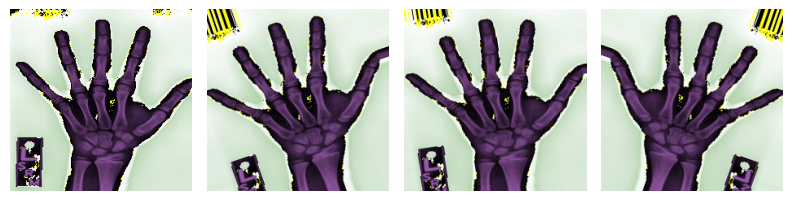

----------------------------------------------------------------------------------------------------
Training with augmentation parameters: aug_num=3, aug_rot_range=20, aug_zoom_range=0, fake_g_float=0.6, fake_b_float=1.1, clahe=False
----------------------------------------------------------------------------------------------------


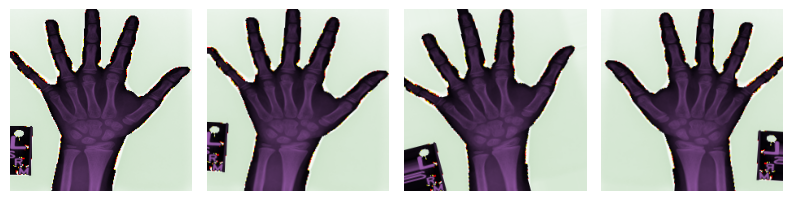

----------------------------------------------------------------------------------------------------
Training with augmentation parameters: aug_num=3, aug_rot_range=20, aug_zoom_range=0, fake_g_float=0.6, fake_b_float=1.2, clahe=True
----------------------------------------------------------------------------------------------------


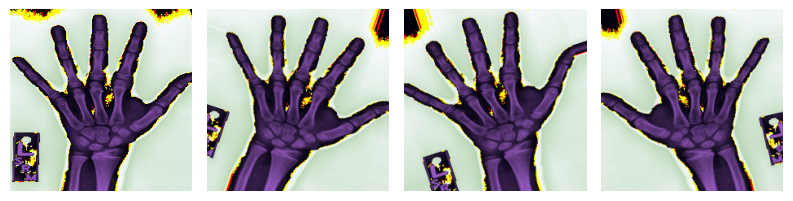

----------------------------------------------------------------------------------------------------
Training with augmentation parameters: aug_num=3, aug_rot_range=20, aug_zoom_range=0, fake_g_float=0.6, fake_b_float=1.2, clahe=False
----------------------------------------------------------------------------------------------------


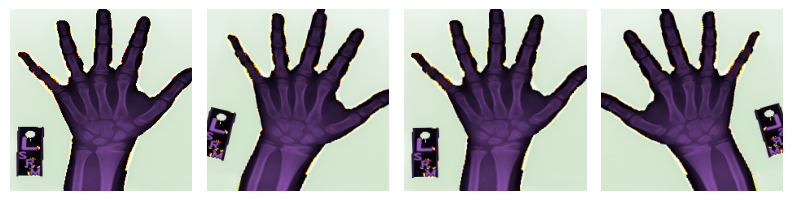

----------------------------------------------------------------------------------------------------
Training with augmentation parameters: aug_num=3, aug_rot_range=20, aug_zoom_range=0, fake_g_float=0.6, fake_b_float=1.3, clahe=True
----------------------------------------------------------------------------------------------------


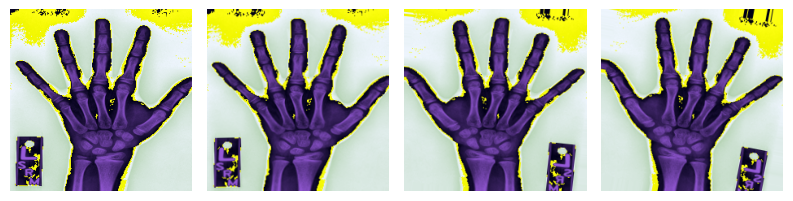

----------------------------------------------------------------------------------------------------
Training with augmentation parameters: aug_num=3, aug_rot_range=20, aug_zoom_range=0, fake_g_float=0.6, fake_b_float=1.3, clahe=False
----------------------------------------------------------------------------------------------------


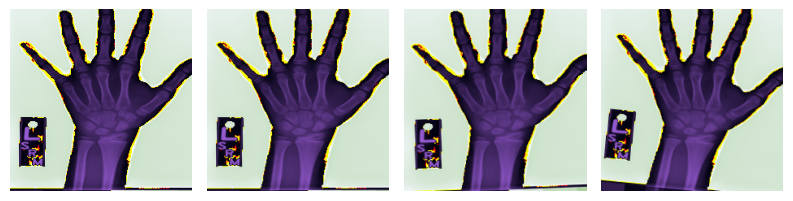

----------------------------------------------------------------------------------------------------
Training with augmentation parameters: aug_num=3, aug_rot_range=20, aug_zoom_range=0, fake_g_float=0.7, fake_b_float=1.1, clahe=True
----------------------------------------------------------------------------------------------------


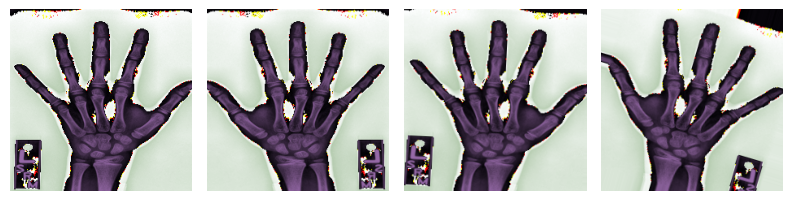

----------------------------------------------------------------------------------------------------
Training with augmentation parameters: aug_num=3, aug_rot_range=20, aug_zoom_range=0, fake_g_float=0.7, fake_b_float=1.1, clahe=False
----------------------------------------------------------------------------------------------------


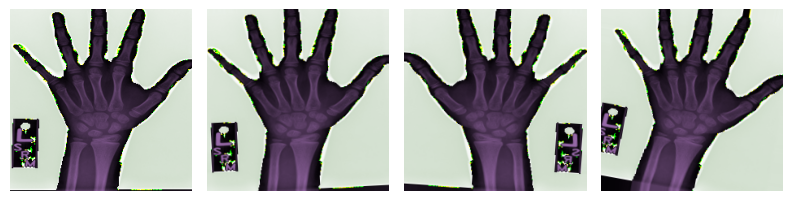

----------------------------------------------------------------------------------------------------
Training with augmentation parameters: aug_num=3, aug_rot_range=20, aug_zoom_range=0, fake_g_float=0.7, fake_b_float=1.2, clahe=True
----------------------------------------------------------------------------------------------------


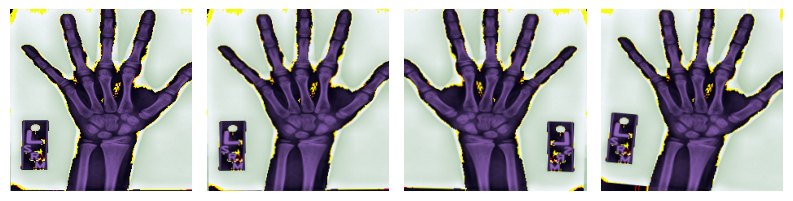

----------------------------------------------------------------------------------------------------
Training with augmentation parameters: aug_num=3, aug_rot_range=20, aug_zoom_range=0, fake_g_float=0.7, fake_b_float=1.2, clahe=False
----------------------------------------------------------------------------------------------------


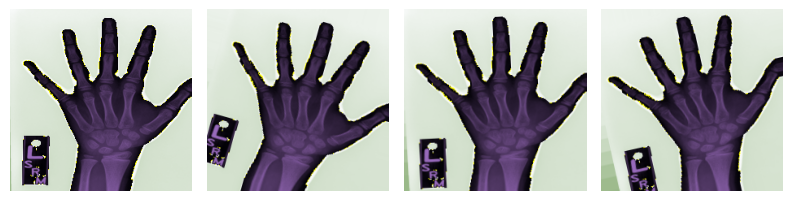

----------------------------------------------------------------------------------------------------
Training with augmentation parameters: aug_num=3, aug_rot_range=20, aug_zoom_range=0, fake_g_float=0.7, fake_b_float=1.3, clahe=True
----------------------------------------------------------------------------------------------------


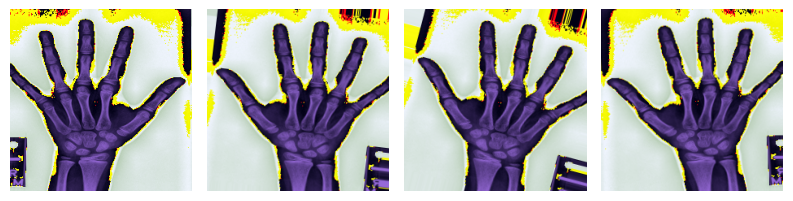

----------------------------------------------------------------------------------------------------
Training with augmentation parameters: aug_num=3, aug_rot_range=20, aug_zoom_range=0, fake_g_float=0.7, fake_b_float=1.3, clahe=False
----------------------------------------------------------------------------------------------------


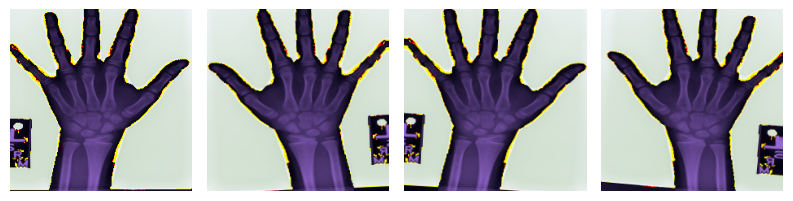

----------------------------------------------------------------------------------------------------
Training with augmentation parameters: aug_num=3, aug_rot_range=20, aug_zoom_range=0, fake_g_float=0.8, fake_b_float=1.1, clahe=True
----------------------------------------------------------------------------------------------------


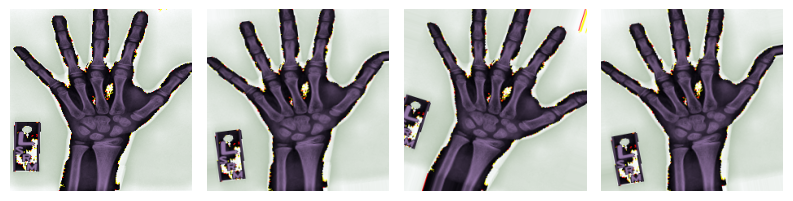

----------------------------------------------------------------------------------------------------
Training with augmentation parameters: aug_num=3, aug_rot_range=20, aug_zoom_range=0, fake_g_float=0.8, fake_b_float=1.1, clahe=False
----------------------------------------------------------------------------------------------------


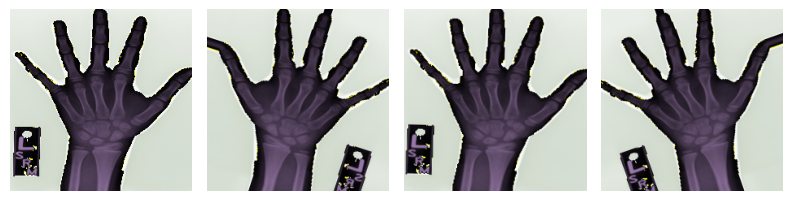

----------------------------------------------------------------------------------------------------
Training with augmentation parameters: aug_num=3, aug_rot_range=20, aug_zoom_range=0, fake_g_float=0.8, fake_b_float=1.2, clahe=True
----------------------------------------------------------------------------------------------------


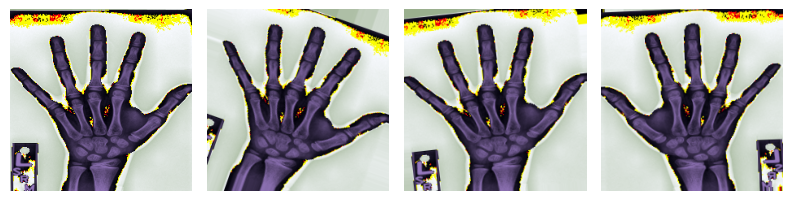

----------------------------------------------------------------------------------------------------
Training with augmentation parameters: aug_num=3, aug_rot_range=20, aug_zoom_range=0, fake_g_float=0.8, fake_b_float=1.2, clahe=False
----------------------------------------------------------------------------------------------------


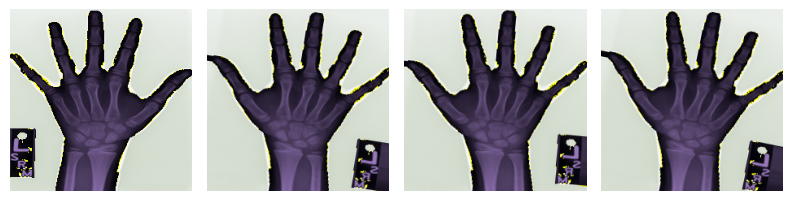

----------------------------------------------------------------------------------------------------
Training with augmentation parameters: aug_num=3, aug_rot_range=20, aug_zoom_range=0, fake_g_float=0.8, fake_b_float=1.3, clahe=True
----------------------------------------------------------------------------------------------------


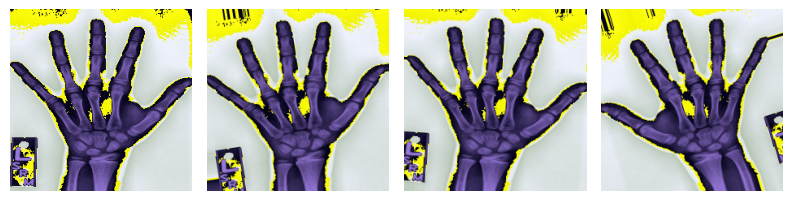

----------------------------------------------------------------------------------------------------
Training with augmentation parameters: aug_num=3, aug_rot_range=20, aug_zoom_range=0, fake_g_float=0.8, fake_b_float=1.3, clahe=False
----------------------------------------------------------------------------------------------------


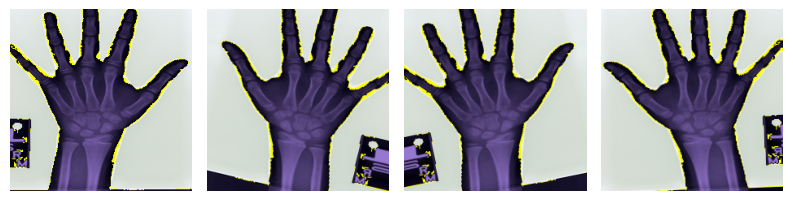

In [ ]:
test_img_paths = img_paths[0:1]

print(test_img_paths)

import itertools
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import time

fake_g_float = [0.6,0.7,0.8]
fake_b_float = [1.1,1.2,1.3]

aug_num_options = [3]  # Number of augmented images
aug_rot_range = [20]
aug_zoom_range = [0]
clahe= [True,False]


# Create a list of all combinations of parameters
param_grid = list(itertools.product(aug_num_options, aug_rot_range,aug_zoom_range,fake_g_float, fake_b_float,clahe))

# Placeholder for results
results = []

# print(f"Training with {len(subset)} images")
for aug_num, aug_rot_range, aug_zoom_range, fake_g_float, fake_b_float, clahe in param_grid:
    start = time.time()
    print("-"*100)
    print(f"Training with augmentation parameters: aug_num={aug_num}, aug_rot_range={aug_rot_range}, aug_zoom_range={aug_zoom_range}, fake_g_float={fake_g_float}, fake_b_float={fake_b_float}, clahe={clahe}")
    print("-"*100)

    # Call your function for processing images
    (augmented_image_vectors, augmented_image_labels, augmented_image_sex) = load_and_preprocess_test_images(
        test_img_paths,
        target_size=(224, 224),
        aug_num=aug_num,
        aug_rot_range=aug_rot_range,
        aug_zoom_range=aug_zoom_range,
        fake_g_float=fake_g_float,
        fake_b_float=fake_b_float,
        clahe=clahe
    )

    # Plot the augmented image vectors
    plt.figure(figsize=(10, 10))
    # Limit the number of images to plot (e.g., 25 images or the length of augmented_image_vectors)
    num_images_to_plot = min(len(augmented_image_vectors), 25)
    for i in range(num_images_to_plot):
        plt.subplot(5, 5, i + 1)  # Create a 5x5 grid of images
        plt.imshow(augmented_image_vectors[i])  # Assuming images are in RGB or grayscale format
        plt.axis('off')  # Hide axis for clarity

    plt.tight_layout()  # To avoid overlap in the plot
    plt.show()  # Display the plot


Above, we can detect that clahe is doing a very good job seperating handbones by contrast, especially carpal bones. We will use 2 different tresholds for fake rgb creation (1,0.8,1.2) and (1,0.7,1.3) in the training to see how they impact the training performance.


#### Trial to remove banner


In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Load the image
# image_path = "/content/dataset_subset/boneage-training-dataset/10033.png"

def remove_banner(image_numpy):
    # Check if the image is already grayscale (1 channel)
    if len(image_numpy.shape) == 3 and image_numpy.shape[2] == 3:
        # If it's a color image (3 channels), convert to grayscale
        gray = cv2.cvtColor(image_numpy, cv2.COLOR_BGR2GRAY)
    elif len(image_numpy.shape) == 2:
        # If it's already grayscale (1 channel), use it as is
        gray = image_numpy
    else:
        raise ValueError("Input image must have either 1 or 3 channels")

    # Step 1: Threshold the brightest regions (detect the label area)
    _, bright_mask = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY)

    # Step 2: Expand the mask to cover nearby remnants
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))  # Increase the size of the kernel for dilation
    expanded_mask = cv2.dilate(bright_mask, kernel, iterations=2)  # Expand the mask further

    # Step 3: Inpaint the expanded masked region
    inpainted_image = cv2.inpaint(image_numpy, expanded_mask, inpaintRadius=5, flags=cv2.INPAINT_TELEA)

    # Return the inpainted image as a NumPy array
    return inpainted_image
# # Save and display results
# cv2.imwrite("/mnt/data/complete_label_removed_image.png", inpainted_image)

# # Visualize the results
# plt.figure(figsize=(15, 10))
# plt.subplot(1, 3, 1)
# plt.title("Original Image")
# plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
# plt.axis("off")

# plt.subplot(1, 3, 2)
# plt.title("Expanded Mask")
# plt.imshow(expanded_mask, cmap="gray")
# plt.axis("off")

# plt.subplot(1, 3, 3)
# plt.title("Image After Artifact Removal")
# plt.imshow(cv2.cvtColor(inpainted_image, cv2.COLOR_BGR2RGB))
# plt.axis("off")

# plt.show()

### Model

#### CNN (3-layer, no-gender, no regularization)

In [ ]:
# Define a simple CNN model for age prediction
def create_cnn_model(input_shape=(224, 224, 1)):
    model = models.Sequential()

    # Convolutional layers
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Flatten the convolutional output
    model.add(layers.Flatten())

    # Fully connected layers
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))  # Prevent overfitting
    model.add(layers.Dense(64, activation='relu'))

    # Output layer for regression
    model.add(layers.Dense(1, activation='linear'))  # Linear activation for regression

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model


#### CNN (3-layer, no-gender, w regularization)

In [ ]:
def create_cnn_model(input_shape=(224, 224, 3)):
    model = models.Sequential()

    # Convolutional layers with Batch Normalization
    model.add(layers.Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Global Average Pooling
    model.add(layers.GlobalAveragePooling2D())

    # Fully connected layers
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(64, activation='relu'))

    # Output layer for regression
    model.add(layers.Dense(1, activation='linear'))  # Linear activation for regression

    # Compile the model
    model.compile(optimizer="adam", loss='mean_squared_error', metrics=['mae'])
    return model

#### CNN (3-layer, w gender, w regularization)

In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.losses import Loss
import tensorflow.keras.backend as K

# Define custom RMSE loss function
def rmse_loss(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))


def create_improved_model(input_shape_image=(224, 224, 3), input_shape_gender=(1,)):
    image_input = layers.Input(shape=input_shape_image)
    gender_input = layers.Input(shape=input_shape_gender)

    # CNN part for image processing
    x = layers.Conv2D(32, (3, 3), padding='same')(image_input)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(64, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(128, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Global Average Pooling
    x = layers.GlobalAveragePooling2D()(x)

    # Dense layers for image features
    x = layers.Dense(512, activation='relu')(x)  # Reduced size

    # Dense layer for gender input
    gender = layers.Dense(32, activation='relu')(gender_input)

    # Combine image features and gender
    combined = layers.concatenate([x, gender])

    # Additional dense layers for combined information
    combined = layers.Dense(1000, activation='relu')(combined)
    combined = layers.Dense(1000, activation='relu')(combined)

    # Output layer for regression (months)
    output = layers.Dense(1, activation='linear')(combined)

    # Model
    model = models.Model(inputs=[image_input, gender_input], outputs=output)

    # Set a specific learning rate
    learning_rate = 0.001  # Example learning rate
    optimizer = Adam(learning_rate=learning_rate)

    # Sgd optimizer diverges, not good to use.
    #optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    # Compile the model with the custom optimizer
    #model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    model.compile(optimizer=optimizer, loss=rmse_loss, metrics=['mae'])
    # Compile the model
    #model.compile(optimizer="adam", loss='mean_squared_error', metrics=['mae'])

    return model


#### CNN (3-layer (5x5), w gender, w regularization)

In [21]:
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Loss
import tensorflow.keras.backend as K

# Define custom RMSE loss function
def rmse_loss(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def create_improved_model(input_shape_image=(56, 56, 3), input_shape_gender=(1,)):
    # Image input
    image_input = layers.Input(shape=input_shape_image)

    # CNN part for image processing
    x = layers.Conv2D(64, (5, 5), padding='same', kernel_regularizer=regularizers.l2(0.01))(image_input)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(128, (5, 5), padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(256, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)

    # Global Average Pooling
    x = layers.GlobalAveragePooling2D()(x)

    # Dense layers for image features
    x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.Dropout(0.5)(x)

    # Gender input
    gender_input = layers.Input(shape=input_shape_gender)
    gender = layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01))(gender_input)
    gender = layers.Dropout(0.3)(gender)

    # Combine image features and gender
    combined = layers.concatenate([x, gender])

    # Additional dense layers for combined information
    combined = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(combined)
    combined = layers.Dropout(0.5)(combined)
    combined = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(combined)

    # Output layer for regression (months)
    output = layers.Dense(1, activation='linear')(combined)

    # Model definition
    model = models.Model(inputs=[image_input, gender_input], outputs=output)

    learning_rate = 0.001
    #optimizer = SGD(learning_rate=learning_rate, momentum=0.9)

    optimizer = Adam(learning_rate=learning_rate)

    #model.compile(optimizer=optimizer, loss='huber', metrics=['mae'])
    #use root mean squared error
    model.compile(optimizer=optimizer, loss=rmse_loss, metrics=['mae'])
    #model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    return model


### SNN Model

- Gender information at dense layer
- Normalize age (0-1)
- Weight Regularization (L2)
- Spike Sparsity
- Noise Injection



In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

In [6]:
class SpikingLayer(layers.Layer):
    def __init__(self, filters, tau=20.0, regularizer=None, **kwargs):
        super(SpikingLayer, self).__init__(**kwargs)
        self.filters = filters
        self.tau = tau
        self.regularizer = regularizers.get(regularizer)

    def build(self, input_shape):
        # Define kernel weights for convolution
        self.kernel = self.add_weight(
            shape=(3, 3, input_shape[-1], self.filters),  # 3x3 convolution
            initializer="glorot_uniform",
            regularizer=self.regularizer,
            trainable=True,
            name="kernel",
        )
        self.bias = self.add_weight(
            shape=(self.filters,),
            initializer="zeros",
            trainable=True,
            name="bias",
        )
        # Initialize membrane potential to match input spatial dimensions
        self.v = tf.Variable(
            tf.zeros((input_shape[1], input_shape[2], self.filters)),
            trainable=False,
            name="membrane_potential"
        )

    def call(self, inputs):
        # Perform 2D convolution
        z = tf.nn.conv2d(inputs, self.kernel, strides=[1, 1, 1, 1], padding="SAME")
        z = tf.nn.bias_add(z, self.bias)
        z = tf.nn.relu(z)  # Activation

        # Update membrane potential with leaky integration
        self.v.assign(self.v * tf.exp(-1 / self.tau) + z)

        # Generate spikes when membrane potential exceeds threshold
        spikes = tf.cast(self.v > 1.0, tf.float32)
        self.v.assign(self.v * (1 - spikes))  # Reset membrane potential after spike
        return spikes

    def compute_output_shape(self, input_shape):
        # Output shape is the same as input shape, except for the filter dimension
        return (input_shape[0], input_shape[1], input_shape[2], self.filters)

# Spike sparsity loss function
def spike_sparsity_loss(spikes):
    return tf.reduce_mean(tf.square(spikes))

def create_snn_model(input_shape_image=(224, 224, 3), input_shape_gender=(1,), regularization=0.01):
    # Image input
    image_input = layers.Input(shape=input_shape_image)

    # Noise injection
    x = layers.GaussianNoise(0.1)(image_input)

    # Spiking layers for image processing
    x = SpikingLayer(64, regularizer=regularizers.l2(regularization))(x)
    x = SpikingLayer(128, regularizer=regularizers.l2(regularization))(x)
    x = SpikingLayer(256, regularizer=regularizers.l2(regularization))(x)

    # Global Average Pooling to reduce spatial dimensions
    x = layers.GlobalAveragePooling2D()(x)  # Output shape: (None, 256)

    # Gender input
    gender_input = layers.Input(shape=input_shape_gender)
    gender = layers.Dense(32, activation="relu", kernel_regularizer=regularizers.l2(regularization))(gender_input)

    # Combine image and gender features
    combined = layers.concatenate([x, gender])  # Now shapes match: (None, 256) and (None, 32)

    # Dense layers for combined features
    combined = layers.Dense(512, activation="relu", kernel_regularizer=regularizers.l2(regularization))(combined)
    combined = layers.Dense(256, activation="relu", kernel_regularizer=regularizers.l2(regularization))(combined)

    # Output layer (spike rate decoding)
    output = layers.Dense(1, activation="linear")(combined)

    # Define the model
    model = models.Model(inputs=[image_input, gender_input], outputs=output)

    # Compile the model with RMSE loss and MAE metrics
    def rmse_loss(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss=rmse_loss,
        metrics=["mae"]
    )

    return model

snn_model = create_snn_model(input_shape_image=(224, 224, 3), input_shape_gender=(1,))
snn_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gaussian_noise_3          │ (None, 224, 224, 3)    │              0 │ input_layer_5[0][0]    │
│ (GaussianNoise)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spiking_layer_7           │ (None, 224, 224, 64)   │          1,792 │ gaussian_noise_3[0][0] │
│ (SpikingLayer)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spiking_layer_8           │ (None, 224, 224, 128)  │         73,856 │ spiking_layer_7[0][0]  │
│ (SpikingLayer)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spiking_layer_9           │ (None, 224, 224, 256)  │        295,168 │ spiking_layer_8[0][0]  │
│ (SpikingLayer)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_6             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 256)            │              0 │ spiking_layer_9[0][0]  │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 32)             │             64 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 288)            │              0 │ global_average_poolin… │
│ (Concatenate)             │                        │                │ dense_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 512)            │        147,968 │ concatenate_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 256)            │        131,328 │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 1)              │            257 │ dense_7[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 650,433 (2.48 MB)

 Trainable params: 650,433 (2.48 MB)

 Non-trainable params: 0 (0.00 B)

 ### Training

#### CNN

In [ ]:
import itertools
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import time

aug_num_options = [1]  # Number of augmented images
aug_rot_range = [10]
aug_zoom_range = [0]
clahe= [True]


# Create a list of all combinations of parameters
param_grid = list(itertools.product(aug_num_options, aug_rot_range,aug_zoom_range,clahe))

# Placeholder for results
results = []

print(f"Training with original {len(subset)} images + Augmented {len(subset)* aug_num_options[0]} images")
for aug_num, aug_rot_range, aug_zoom_range, clahe in param_grid:
    gb_thresholds = [(0.8,1.2)]
    for fake_g_float, fake_b_float in gb_thresholds:
      start = time.time()
      print("-"*100)
      print(f"Training with augmentation parameters: aug_num={aug_num}, aug_rot_range={aug_rot_range}, aug_zoom_range={aug_zoom_range}, fake_g_float={fake_g_float}, fake_b_float={fake_b_float}, clahe={clahe}")
      print("-"*100)

      # Call your function for processing images
      (augmented_image_vectors, augmented_image_labels, augmented_image_sex) = load_and_preprocess_test_images(
          img_paths,
          target_size=(224, 224),
          aug_num=aug_num,
          aug_rot_range=aug_rot_range,
          aug_zoom_range=aug_zoom_range,
          fake_g_float=fake_g_float,
          fake_b_float=fake_b_float,
          clahe=clahe
      )
      # Perform train-test split
      X_train, X_test, y_train, y_test = train_test_split(
          augmented_image_vectors, augmented_image_labels, test_size=0.2, random_state=42
      )
      # Split the training data into new training and validation sets
      X_train, X_val, y_train, y_val = train_test_split(
          X_train, y_train, test_size=0.2, random_state=42  # Adjust `test_size` as needed
      )


      # # Print the shapes of the resulting splits
      # print("Training data shape:", X_train.shape, y_train.shape)
      # print("Validation data shape:", X_val.shape, y_val.shape)
      # print("Testing data shape:", X_test.shape, y_test.shape)

      cnn_model = create_cnn_model(input_shape=(150, 150, 3))

      # Train the model
      history = cnn_model.fit(
          X_train, y_train,
          validation_data=(X_val, y_val),
          epochs=10,  # Number of epochs
          batch_size=32,  # Batch size
          verbose=1  # Print training progress
      )

      # Evaluate on validation data
      val_loss, val_mae = cnn_model.evaluate(X_val, y_val, verbose=1)
      print(f"Validation Loss: {val_loss:.4f}, Validation MAE: {val_mae:.4f}")

      # Predict ages on test data
      predicted_ages = cnn_model.predict(X_test)

      # Calculate the Mean Absolute Error (MAE)
      mae = mean_absolute_error(y_test, predicted_ages)

      # Calculate the R^2 Score
      r2 = r2_score(y_test, predicted_ages)

      # Print the evaluation metrics
      print(f"Test Scores:")
      print(f"Mean Absolute Error (MAE): {mae}")
      print(f"R^2 Score: {r2}")
      print(f"Time taken: {time.time() - start}")


Training with original 1261 images + Augmented 1261 images
----------------------------------------------------------------------------------------------------
Training with augmentation parameters: aug_num=1, aug_rot_range=10, aug_zoom_range=0, fake_g_float=0.8, fake_b_float=1.2, clahe=True
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 300s 7s/step - loss: 14674.6924 - mae: 112.7910 - val_loss: 14687.7480 - val_mae: 114.0465
Epoch 2/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 291s 7s/step - loss: 1821.3987 - mae: 34.4790 - val_loss: 5017.8755 - val_mae: 61.8729
Epoch 3/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 317s 7s/step - loss: 1606.1610 - mae: 32.8490 - val_loss: 1756.5333 - val_mae: 33.3907
Epoch 4/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 314s 6s/step - loss: 1637.9923 - mae: 33.1944 - val_loss: 2222.2695 - val_mae: 35.3501
Epoch 5/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 283s 6s/step - loss: 1587.3702 - mae: 32.6143 - val_loss: 3263.7515 - val_mae: 43.9104
Epoch 6/10
41/44 ━━━━━━━━━━━━━━━━━━━━ 18s 6s/step - loss: 1554.8020 - mae: 31.6081

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-20-e47ed188d4fa>", line 55, in <cell line: 18>
    history = cnn_model.fit(
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 320, in fit
    logs = self.train_function(iterator)
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py", line 833, in __call__
    result = self._call(*args, **kwds)
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/polymorphic_f

TypeError: object of type 'NoneType' has no len()

#### CNN + Gender, 3 layers basic

In [ ]:
import itertools
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import time

aug_num_options = [2]  # Number of augmented images
aug_rot_range = [10]
aug_zoom_range = [0]
clahe = [True]

# Create a list of all combinations of parameters
param_grid = list(itertools.product(aug_num_options, aug_rot_range, aug_zoom_range, clahe))

# Placeholder for results
results = []

print(f"Training with original {len(img_paths)} images + Augmented {len(img_paths)* aug_num_options[0]} images")
for aug_num, aug_rot_range, aug_zoom_range, clahe in param_grid:
    gb_thresholds = [(0.8, 1.2)]
    for fake_g_float, fake_b_float in gb_thresholds:
        start = time.time()
        print("-"*100)
        print(f"Training with augmentation parameters: aug_num={aug_num}, aug_rot_range={aug_rot_range}, aug_zoom_range={aug_zoom_range}, fake_g_float={fake_g_float}, fake_b_float={fake_b_float}, clahe={clahe}")
        print("-"*100)

        # Call your function for processing images and gender information
        (augmented_image_vectors, augmented_image_labels, augmented_image_sex) = load_and_preprocess_test_images(
            img_paths,
            target_size=(224, 224),
            aug_num=aug_num,
            aug_rot_range=aug_rot_range,
            aug_zoom_range=aug_zoom_range,
            fake_g_float=fake_g_float,
            fake_b_float=fake_b_float,
            clahe=clahe
        )

        # Perform train-test split
        X_train, X_test, y_train, y_test, gender_train, gender_test = train_test_split(
            augmented_image_vectors, augmented_image_labels, augmented_image_sex, test_size=0.2, random_state=42
        )

        # Split the training data into new training and validation sets
        X_train, X_val, y_train, y_val, gender_train, gender_val = train_test_split(
            X_train, y_train, gender_train, test_size=0.2, random_state=42  # Adjust `test_size` as needed
        )

        # Print the shapes of the resulting splits (for debugging)
        # print("Training data shape:", X_train.shape, y_train.shape)
        # print("Validation data shape:", X_val.shape, y_val.shape)
        # print("Testing data shape:", X_test.shape, y_test.shape)

        # Create the new model
        cnn_model = create_improved_model(input_shape_image=(150, 150, 3), input_shape_gender=(1,))

        # Train the model
        history = cnn_model.fit(
            [X_train, gender_train], y_train,  # Use both image and gender data as input
            validation_data=([X_val, gender_val], y_val),  # Validation data with both inputs
            epochs=10,  # Number of epochs
            batch_size=32,  # Batch size
            verbose=1  # Print training progress
        )

        # Evaluate on validation data
        val_loss, val_mae = cnn_model.evaluate([X_val, gender_val], y_val, verbose=1)
        print(f"Validation Loss: {val_loss:.4f}, Validation MAE: {val_mae:.4f}")

        # Predict on test data
        predicted_ages = cnn_model.predict([X_test, gender_test])  # Use both image and gender data for prediction

        # Calculate the Mean Absolute Error (MAE)
        mae = mean_absolute_error(y_test, predicted_ages)

        # Calculate the R^2 Score
        r2 = r2_score(y_test, predicted_ages)

        # Print the evaluation metrics
        print(f"Test Scores:")
        print(f"Mean Absolute Error (MAE): {mae}")
        print(f"R^2 Score: {r2}")
        print(f"Time taken: {time.time() - start}")


Training with original 1261 images + Augmented 2522 images
----------------------------------------------------------------------------------------------------
Training with augmentation parameters: aug_num=2, aug_rot_range=10, aug_zoom_range=0, fake_g_float=0.8, fake_b_float=1.2, clahe=True
----------------------------------------------------------------------------------------------------


NameError: name 'load_and_preprocess_test_images' is not defined

#### CNN + Gender, Regularized, 5x5

In [ ]:
import itertools
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import time

aug_num_options = [2]  # Number of augmented images
aug_rot_range = [10]
aug_zoom_range = [0]
clahe = [True]

# Create a list of all combinations of parameters
param_grid = list(itertools.product(aug_num_options, aug_rot_range, aug_zoom_range, clahe))

# Placeholder for results
results = []

print(f"Training with original {len(img_paths)} images + Augmented {len(img_paths)* aug_num_options[0]} images")
for aug_num, aug_rot_range, aug_zoom_range, clahe in param_grid:
    gb_thresholds = [(0.8, 1.2)]
    for fake_g_float, fake_b_float in gb_thresholds:
        start = time.time()
        print("-"*100)
        print(f"Training with augmentation parameters: aug_num={aug_num}, aug_rot_range={aug_rot_range}, aug_zoom_range={aug_zoom_range}, fake_g_float={fake_g_float}, fake_b_float={fake_b_float}, clahe={clahe}")
        print("-"*100)

        # Call your function for processing images and gender information
        (augmented_image_vectors, augmented_image_labels, augmented_image_sex) = load_and_preprocess_test_images(
            img_paths,
            target_size=(224, 224),
            aug_num=aug_num,
            aug_rot_range=aug_rot_range,
            aug_zoom_range=aug_zoom_range,
            fake_g_float=fake_g_float,
            fake_b_float=fake_b_float,
            clahe=clahe
        )

        # Perform train-test split
        X_train, X_test, y_train, y_test, gender_train, gender_test = train_test_split(
            augmented_image_vectors, augmented_image_labels, augmented_image_sex, test_size=0.2, random_state=42
        )

        # Split the training data into new training and validation sets
        X_train, X_val, y_train, y_val, gender_train, gender_val = train_test_split(
            X_train, y_train, gender_train, test_size=0.2, random_state=42  # Adjust `test_size` as needed
        )

        # Print the shapes of the resulting splits (for debugging)
        # print("Training data shape:", X_train.shape, y_train.shape)
        # print("Validation data shape:", X_val.shape, y_val.shape)
        # print("Testing data shape:", X_test.shape, y_test.shape)

        # Create the new model
        cnn_model = create_improved_model(input_shape_image=(150, 150, 3), input_shape_gender=(1,))

        # Train the model
        history = cnn_model.fit(
            [X_train, gender_train], y_train,  # Use both image and gender data as input
            validation_data=([X_val, gender_val], y_val),  # Validation data with both inputs
            epochs=10,  # Number of epochs
            batch_size=32,  # Batch size
            verbose=1  # Print training progress
        )

        # Evaluate on validation data
        val_loss, val_mae = cnn_model.evaluate([X_val, gender_val], y_val, verbose=1)
        print(f"Validation Loss: {val_loss:.4f}, Validation MAE: {val_mae:.4f}")

        # Predict on test data
        predicted_ages = cnn_model.predict([X_test, gender_test])  # Use both image and gender data for prediction

        # Calculate the Mean Absolute Error (MAE)
        mae = mean_absolute_error(y_test, predicted_ages)

        # Calculate the R^2 Score
        r2 = r2_score(y_test, predicted_ages)

        # Print the evaluation metrics
        print(f"Test Scores:")
        print(f"Mean Absolute Error (MAE): {mae}")
        print(f"R^2 Score: {r2}")
        print(f"Time taken: {time.time() - start}")


Training with original 12611 images + Augmented 25222 images
----------------------------------------------------------------------------------------------------
Training with augmentation parameters: aug_num=2, aug_rot_range=10, aug_zoom_range=0, fake_g_float=0.8, fake_b_float=1.2, clahe=True
----------------------------------------------------------------------------------------------------


NameError: name 'load_and_preprocess_test_images' is not defined

### Tensorflow converted functions

In [49]:
pip install --upgrade tensorflow

  Using cached tensorflow-2.18.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.1 kB)
  Using cached tensorboard-2.18.0-py3-none-any.whl.metadata (1.6 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 3.7 MB/s eta 0:00:00
Using cached tensorflow-2.18.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (615.3 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 50.4 MB/s eta 0:00:00
Using cached tensorboard-2.18.0-py3-none-any.whl (5.5 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.12.3
    Uninstalling tensorboard-2.12.3:
      Successfully uninstalled tensorboard-2.12.3
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.

In [50]:
pip install --upgrade tf-models-official

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 44.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2


In [45]:
pip install tensorflow-addons

In [51]:
import tensorflow as tf
import tensorflow_addons as tfa

AttributeError: module 'keras._tf_keras.keras.layers' has no attribute 'AbstractRNNCell'

In [52]:
def apply_rotation_tf(image, max_angle, target_size=(224, 224)):
    # max_angle=10
    max_angle = tf.minimum(max_angle, 10.0)
    # Convert degrees to radians
    angle_rad = tf.random.uniform([], -max_angle, max_angle) * (3.14159265 / 180)

    # Rotate the image
    rotated_image = tfa.image.rotate(image, angles=angle_rad, interpolation="BILINEAR")

    # Resize the image to the target size
    rotated_image = tf.image.resize(rotated_image, target_size)

    # Normalize the pixel values to [0, 1]
    rotated_image = tf.clip_by_value(rotated_image, 0.0, 1.0)

    return rotated_image

In [42]:

def apply_rotation_tf(image, max_angle=10, target_size=(224, 224)):
    # Ensure max_angle is limited to 10 degrees
    max_angle = tf.minimum(max_angle, 10)

    # Convert degrees to radians
    angle_rad = tf.random.uniform([], -max_angle, max_angle) * (3.14159265 / 180)

    # Rotate the image using TensorFlow's image rotation
    rotated_image = tfa.image.rotate(image, angles=angle_rad, interpolation="BILINEAR")

    # Resize the image to target size
    rotated_image = tf.image.resize(rotated_image, target_size)

    # Normalize the pixel values to [0, 1]
    rotated_image = tf.clip_by_value(rotated_image, 0.0, 1.0)

    return rotated_image

### TF, Dataset implementation

In [22]:
import re
import numpy as np
#! the first cell of preprocessing part must be run before this
labels = []
sexes = []
for img_path in img_paths:
  case_id = int(re.search(r'\d+', os.path.basename(img_path)).group())
  label = labels_df.loc[labels_df['id'] == case_id, "boneage"].values[0]
  sex = labels_df.loc[labels_df['id'] == case_id, 'male'].values[0]
  labels.append(label)
  sexes.append(sex)

#normalize the labels between [0,1]
min_label = min(labels)
max_label = max(labels)
labels = [(label - min_label) / (max_label - min_label) for label in labels]
labels = np.array(labels)
#create a dataframe out of (img_paths,labels,sex)
dfd = pd.DataFrame({'img_path': img_paths, 'boneage': labels, 'male': sex})
dfd.head()

img_path   boneage   male
0  /content/dataset_subset/boneage-training-datas...  0.462555  False
1  /content/dataset_subset/boneage-training-datas...  0.788546  False
2  /content/dataset_subset/boneage-training-datas...  0.299559  False
3  /content/dataset_subset/boneage-training-datas...  0.682819  False
4  /content/dataset_subset/boneage-training-datas...  0.444934  False

New preprocess trial

In [23]:
import re
import numpy as np
from PIL import Image
import random
import tensorflow_models as tfm
import tensorflow as tf

def clahe_enhancement_tf(img):
    # Apply contrast adjustment (as an approximation of CLAHE)
    img = tf.image.adjust_contrast(img, contrast_factor=2.0)

    return img
# def create_false_rgb_image_tf(enhanced_img, fake_g_float, fake_b_float):
#     # Convert the grayscale image to a 3-channel image (RGB)
#     enhanced_img = tf.expand_dims(enhanced_img, axis=-1)  # Add the channel dimension

#     # Replicate the grayscale image across the 3 channels (RGB)
#     false_rgb = tf.concat([enhanced_img] * 3, axis=-1)

#     # Modify the channels to create the false color effect
#     false_rgb = tf.stack([
#         false_rgb[:, :, 0],  # Red channel (same as the grayscale)
#         false_rgb[:, :, 1] * fake_g_float,  # Green channel (adjusted)
#         false_rgb[:, :, 2] * fake_b_float   # Blue channel (adjusted)
#     ], axis=-1)

#     # Ensure the values are in the range [0, 255]
#     false_rgb = tf.clip_by_value(false_rgb, 0.0, 1.0)  # Normalize between 0 and 1 (for TensorFlow)

#     return false_rgb
def create_false_rgb_image_tf(enhanced_img, fake_g_float, fake_b_float):
    # Since enhanced_img is a 3-channel image, all channels have identical grayscale values.
    # Modify the channels to create the false color effect
    false_rgb = tf.stack([
        enhanced_img[:, :, 0],  # Red channel (same as the grayscale)
        enhanced_img[:, :, 1] * fake_g_float,  # Green channel (adjusted)
        enhanced_img[:, :, 2] * fake_b_float   # Blue channel (adjusted)
    ], axis=-1)

    # Ensure the values are in the range [0, 255]
    #false_rgb = tf.clip_by_value(false_rgb, 0.0, 1.0)  # Normalize between 0 and 1 (for TensorFlow)

    return false_rgb


def random_crop(image, crop_size):

    # Use TensorFlow's shape instead of .size
    height, width, _ = image.shape

    # Perform cropping (use tf.image.random_crop or manual slicing)
    crop_height, crop_width = crop_size
    cropped_img = tf.image.random_crop(image, size=[crop_height, crop_width, 3])  # Assuming 3 channels
    return cropped_img

# def load_and_preprocess_tf(image_path, sex, label, fake_g_float,fake_b_float,clahe = True):

#     # img = Image.open(image_path)

#     # # Resize the image to the (256x256) # CHECK EFFECT
#     # img = img.resize((256,256))
#     img = tf.io.read_file(image_path)
#     img = tf.image.decode_jpeg(img, channels=3)  # Decode as RGB (3 channels)

#     # Resize the image to (256, 256)
#     img = tf.image.resize(img, [256, 256])

#     # Convert the image to a numpy array
#     img_array = np.array(img)

#     # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)   #CHECK EFFECT
#     if clahe:
#       img_array = clahe_enhancement(img_array)

#     #apply gamma
#     #img_array = gamma_correction(img_array)

#     # #apply log
#     #img_array = log_transformation(img_array)
#     # create false RGB
#     img_array = create_false_rgb_image(img_array, fake_g_float,fake_b_float)

#     #subtract mean from all channels and then divide by standard deviation
#     # img_array[:,:,0] = img_array[:,:,0] - np.mean(img_array[:,:,0])
#     # img_array[:,:,1] = img_array[:,:,1] - np.mean(img_array[:,:,1])
#     # img_array[:,:,2] = img_array[:,:,2] - np.mean(img_array[:,:,2])

#     # Normalize the pixel values (scale to 0-1)
#     # min_val = np.min(img_array)
#     # max_val = np.max(img_array)
#     # img_array = (img_array - min_val) / (max_val - min_val)
#     img_array = img_array / 255.0
#     return img_array, sex, label

def load_and_preprocess_tf(image_path, sex, label, fake_g_float, fake_b_float, clahe=True):
    # Read the image from the file path using TensorFlow
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)  # Decode as RGB (3 channels)

    # Resize the image to (256, 256)
    #img = tf.image.resize(img, [256, 256])
    img = tf.image.resize(img, [64, 64])
    # Apply CLAHE if needed (CLAHE should also be implemented using TensorFlow)
    if clahe:
        img = clahe_enhancement_tf(img)  # Use TensorFlow-based CLAHE enhancement (not NumPy)

    # Apply false RGB channels (make sure this function uses TensorFlow if needed)
    img = create_false_rgb_image_tf(img, fake_g_float, fake_b_float)  # Ensure TensorFlow ops


    # Normalize the image
    img = img / 255.0

    return img, sex, label

def augment_and_map(img_array, sex, label, aug_num, aug_rot_range, crop_size):
    augmented_images = []

    for _ in range(aug_num):
        # Randomly crop the image using TensorFlow's random_crop
        cropped_img = tf.image.random_crop(img_array, size=(crop_size[0], crop_size[1], 3))  # Assuming 3 channels (RGB)

        # Apply random rotation
        angle = random.uniform(-aug_rot_range, aug_rot_range)  # Rotation angle in degrees
        cropped_img = tfm.vision.augment.rotate(cropped_img, degrees=angle)



        #radians = tf.random.uniform([], minval=-aug_rot_range, maxval=aug_rot_range) * (3.14159265 / 180)
        #cropped_img = tfa.image.rotate(cropped_img, radians)

        # Apply random horizontal flip
        cropped_img = tf.image.random_flip_left_right(cropped_img)

        # Append the augmented image
        augmented_images.append(cropped_img)

    # Stack augmented images and repeat metadata
    return tf.stack(augmented_images), tf.repeat(sex, aug_num), tf.repeat(label, aug_num)


In [24]:
import tensorflow as tf

def create_dataset(df,batch_size, shuffle, cache_file=None):
    # # creating the elements of the dataset
    # labels = []
    # sexes = []
    # for img_path in img_paths:
    #   case_id = int(re.search(r'\d+', os.path.basename(img_path)).group())
    #   label = labels_df.loc[labels_df['id'] == case_id, "boneage"].values[0]
    #   sex = labels_df.loc[labels_df['id'] == case_id, 'male'].values[0]
    #   labels.append(label)
    #   sexes.append(sex)

    labels = df['boneage'].values
    sexes = df['male'].values
    img_paths = df['img_path'].values

    print(img_paths[0:5])
    # Create a Dataset object
    dataset = tf.data.Dataset.from_tensor_slices((img_paths,sexes,labels))

    # Arrange parameters
    fake_g_float = 0.8
    fake_b_float = 1.2
    clahe = True
    aug_num = 1
    aug_rot_range = 10
    crop_size = (56,56)

    # Apply mapping with the load and preprocess function
    dataset = dataset.map(lambda img_path,sex, label: load_and_preprocess_tf(img_path, sex, label, fake_g_float,fake_b_float,clahe), num_parallel_calls=os.cpu_count())

    # # Cache dataset
    # if cache_file:
    #     dataset = dataset.cache(cache_file)
    #use disk caching
    if cache_file:
      dataset = dataset.cache(cache_file)


    # # # Shuffle
    # if shuffle:
    #     dataset = dataset.shuffle(len(img_paths))


    # Apply mapping with the augment_and_map function
    dataset = dataset.map(lambda img_array, sex, label: augment_and_map(img_array, sex, label, aug_num,aug_rot_range,crop_size), num_parallel_calls=os.cpu_count())

    # # Correct input shape for the network
    # dataset = dataset.map(lambda data, label: (tf.expand_dims(data, 1), label))
    # Repeat the dataset indefinitely

    #flatten the dataset
    dataset = dataset.flat_map(lambda data, sex, label: tf.data.Dataset.from_tensor_slices((data, sex, label)))

    #shuffle the dataset
    if shuffle:
        dataset = dataset.shuffle(len(img_paths)*(aug_num))
    # Batch
    dataset = dataset.batch(batch_size=batch_size)

    dataset = dataset.repeat()
    # Prefetch
    #dataset = dataset.prefetch(buffer_size=1)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [25]:
#clear cache
tf.keras.backend.clear_session()

In [26]:
#create dataset
dataset = create_dataset(dfd,batch_size=32, shuffle=True)

['/content/dataset_subset/boneage-training-dataset/12446.png'
 '/content/dataset_subset/boneage-training-dataset/2785.png'
 '/content/dataset_subset/boneage-training-dataset/5829.png'
 '/content/dataset_subset/boneage-training-dataset/3569.png'
 '/content/dataset_subset/boneage-training-dataset/6859.png']


In [27]:
#print the shape of the first element of the dataset
for element in dataset.take(3):
    print(element[0].shape)
    print(element[1].shape)
    print(element[2].shape)
    print(element[0][0].shape)


(32, 56, 56, 3)
(32,)
(32,)
(56, 56, 3)
(32, 56, 56, 3)
(32,)
(32,)
(56, 56, 3)
(32, 56, 56, 3)
(32,)
(32,)
(56, 56, 3)


In [28]:
from tensorflow.keras.callbacks import EarlyStopping
# Define the model
model = create_improved_model(input_shape_image=(56, 56, 3), input_shape_gender=(1,))

# Adjusted preprocess_data function to handle the dataset's structure
def preprocess_data(image, gender, regression_target):
    # Gender input needs to be expanded to shape (batch_size, 1)
    gender_input = tf.expand_dims(gender, axis=-1)
    # Cast regression target to float
    regression_target = tf.cast(regression_target, dtype=tf.float32)
    return (image, gender_input), regression_target
aug_num = 1
batch_size = 32
total_data = len(img_paths) * (aug_num)
#epoch number should be equal to
epochs = 10
steps_per_epoch = (total_data // batch_size) +1
#total_data = len(img_paths) * (aug_num+1)
# Apply mapping, and prefetching
# Preprocess the dataset (no additional batching)
prepared_dataset = dataset.map(preprocess_data).prefetch(tf.data.AUTOTUNE)

# # Fit the model
# history = model.fit(
#     prepared_dataset,
#     epochs=epochs,
#     verbose=1,
#     steps_per_epoch=steps_per_epoch
# )
# Define early stopping callback based on validation MAE
early_stopping = EarlyStopping(
    monitor='mae',    # Monitor Mean Absolute Error
    patience=2,       # Stop after 3 epochs with no improvement
    verbose=1,
    restore_best_weights=True  # Restore the best weights after stopping
)

# Fit the model with early stopping
history = model.fit(
    prepared_dataset,
    epochs=epochs,
    verbose=1,
    steps_per_epoch=steps_per_epoch,
    callbacks=[early_stopping]
)

Epoch 1/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 335s 48ms/step - loss: 4.7463 - mae: 0.2114
Epoch 2/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 300s 14ms/step - loss: 0.2393 - mae: 0.1478
Epoch 3/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 300s 13ms/step - loss: 0.1862 - mae: 0.1478
Epoch 4/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 301s 13ms/step - loss: 0.1828 - mae: 0.1473
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 2.


In [29]:
%matplotlib inline

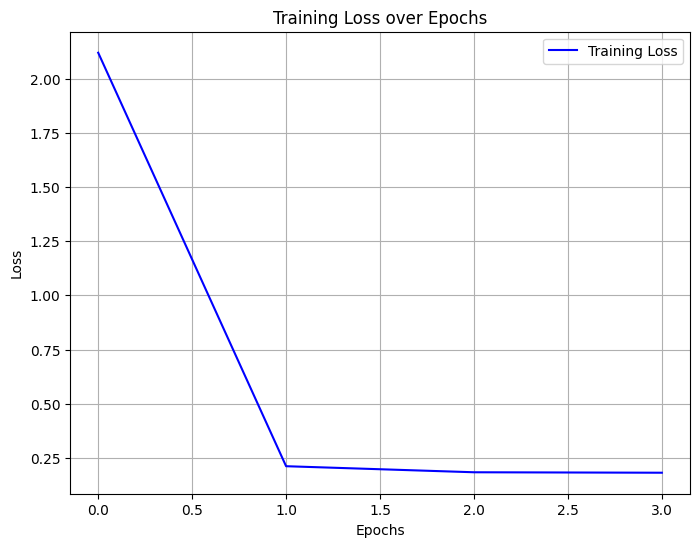

In [30]:
import matplotlib.pyplot as plt

# Extract the loss values from the history object
loss = history.history['loss']

# Plot the loss
plt.figure(figsize=(8, 6))
plt.plot(loss, label='Training Loss', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()


(32, 56, 56, 3)
(32,)
(32,)
(56, 56, 3)


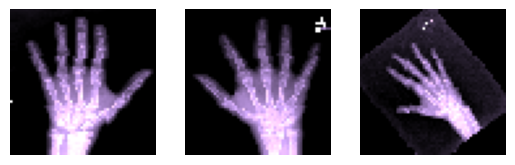

(32, 56, 56, 3)
(32,)
(32,)
(56, 56, 3)


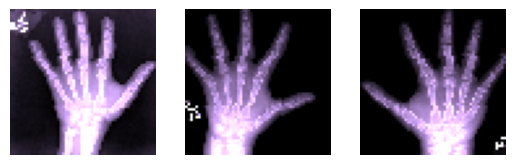

(32, 56, 56, 3)
(32,)
(32,)
(56, 56, 3)


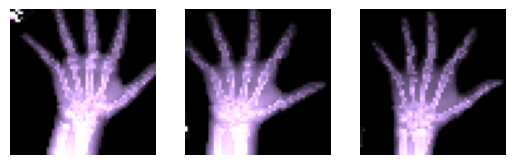

(32, 56, 56, 3)
(32,)
(32,)
(56, 56, 3)


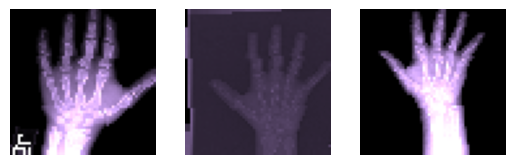

(32, 56, 56, 3)
(32,)
(32,)
(56, 56, 3)


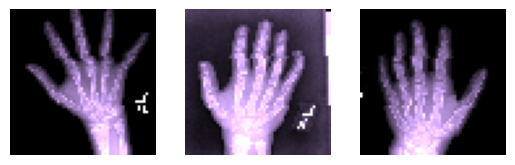

In [31]:
import matplotlib.pyplot as plt
import tensorflow as tf

tf.config.run_functions_eagerly(True)

# Print 10 images from the generated dataset
for element in dataset.take(5):
    # Print the shape of the dataset elements
    print(element[0].shape)  # Image tensor
    print(element[1].shape)  # Label tensor
    print(element[2].shape)  # Additional data tensor
    print(element[0][0].shape)  # Single image tensor

    # Plot 2 images
    for i in range(3):
        plt.subplot(1, 3, i + 1)  # Create a 1x2 grid
        img = element[0][i].numpy()  # Convert to NumPy array
        plt.imshow(img)
        plt.axis("off")  # Hide axes for better visualization

    plt.show()  # Display the plots


TEST too see the prediction accuracy
  

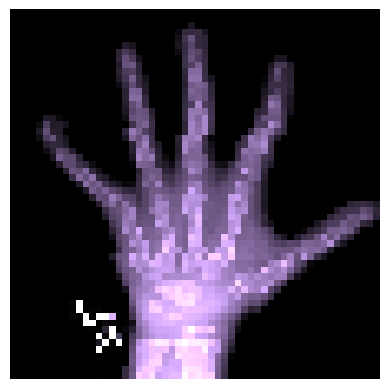

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


False
0.31277533039647576
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 974ms/step
Prediction: [[0.66944796]]


In [32]:
#feed one image and test its prediction
test_img = None
test_gender = None
test_age = None
i = np.random.randint(0, 31)
for element in dataset.take(1):
  test_img = element[0][i]
  test_gender = element[1][i]
  test_age = element[2][i]

plt.imshow(test_img.numpy())
plt.axis("off")  # Hide axes for better visualization
plt.show()  # Display the plots

print(test_gender.numpy())
print(test_age.numpy())


test_img = tf.expand_dims(test_img, axis=0)  # Shape: (1, 224, 224, 3)
test_gender = tf.expand_dims(test_gender, axis=0)  # Shape: (1, 1)

# Make a prediction
prediction = model.predict((test_img, test_gender))
print("Prediction:", prediction)